# Visualize attention map for DINO v2

In [ ]:
import sys

INSTALL = True # Switch this to install dependencies
if INSTALL: # Try installing package with extras
    REPO_URL = "https://github.com/facebookresearch/dinov2"
    !{sys.executable} -m pip install -e {REPO_URL}'#egg=dinov2[extras]' --extra-index-url https://download.pytorch.org/whl/cu117  --extra-index-url https://pypi.nvidia.com
else:
    REPO_PATH = "<FIXME>" # Specify a local path to the repository (or use installed package instead)
    sys.path.append(REPO_PATH)

DEPRECATION: https://github.com/facebookresearch/dinov2#egg=dinov2[extras] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
ERROR: https://github.com/facebookresearch/dinov2#egg=dinov2[extras] is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).


In [1]:
!apt-get -qq install git
!git clone https://github.com/facebookresearch/dinov2
%cd dinov2
!pip install -e .[extras]

fatal: destination path 'dinov2' already exists and is not an empty directory.
/content/dinov2
Obtaining file:///content/dinov2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached torch-2.0.0-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
  Using cached torchvision-0.15.0-cp310-cp310-manylinux1_x86_64.whl (6.0 MB)
  Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
  Using cached torchmetrics-0.10.3-py3-none-any.whl (529 kB)
  Using cached fvcore-0.1.5.post20221221.tar.gz (50 kB)
  Preparing metadata (setup.py) ... done
  Using cached iopath-0.1.10.tar.gz (42 kB)
  Preparing metadata (setup.py) ... done
  Using cached xformers-0.0.18-cp310-cp310-manylinux2014_x86_64.whl (123.8 MB)
  Using cached submitit-1.5.0-py3-none-any.whl (74 kB)
  Using cached cuml-cu11-23.10.0.tar.gz (6.8 kB)
  error: subprocess-exited-with-e

## Utilities

In [2]:
import math
import itertools
from functools import partial

import torch
import torch.nn.functional as F


## Load pretrained backbone

In [3]:
BACKBONE_SIZE = "large" # in ("small", "base", "large" or "giant")


backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone_model = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone_model.eval()
backbone_model.cuda()

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


## Load image

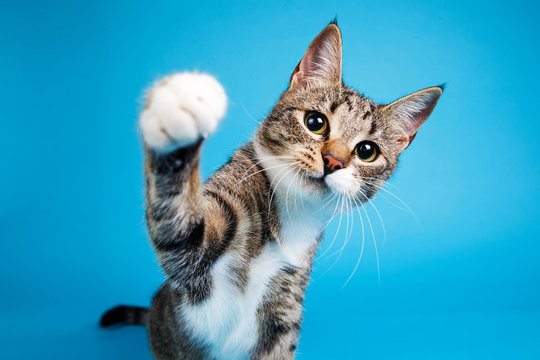

In [4]:
import urllib

from PIL import Image


def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f).convert("RGB")


#EXAMPLE_IMAGE_URL = "https://dl.fbaipublicfiles.com/dinov2/images/example.jpg"
image = Image.open("/content/cat.jpg").convert("RGB")

#image = load_image_from_url(EXAMPLE_IMAGE_URL)
display(image)

In [5]:
import torch
from torchvision import transforms
from PIL import Image

# Load your original image (you can use your own image loading mechanism)
#original_image = Image.open("path_to_your_image.jpg")  # Replace with the path to your image
transform = transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
img = transform(image)

In [6]:
print(img.shape)

torch.Size([3, 448, 448])


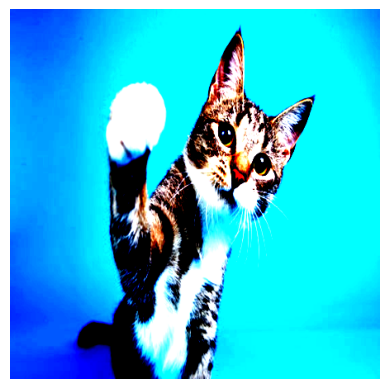

In [6]:
import matplotlib.pyplot as plt

transformed_image_np = img.permute(1, 2, 0).numpy()

# Show the transformed image using matplotlib
plt.imshow(transformed_image_np)
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

In [ ]:
print(tens.shape)

torch.Size([3, 504, 504])


In [ ]:
tens = torch.tensor(resized_image)

<ipython-input-10-dca65e456164>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tens = torch.tensor(resized_image)


In [7]:
tens = img.unsqueeze(0)

In [8]:
tens = tens.to('cuda')

In [9]:
inter = backbone_model.get_intermediate_layers(tens, 10, reshape=True)

In [ ]:
print(backbone_model.embed_dim )

1024


In [ ]:
inter_reshaped = inter[-1][0, 0, :].reshape(1, -1)

In [ ]:
mean_attention_map = inter[-1].mean(dim=1)

In [ ]:
print(mean_attention_map.shape)

torch.Size([1, 32, 32])


In [ ]:
mean_attention_map = mean_attention_map.reshape(1, -1)

In [ ]:
print(inter_reshaped.shape)

torch.Size([1, 1024])


In [ ]:
print(inter[0].shape)

torch.Size([1, 1024, 1024])


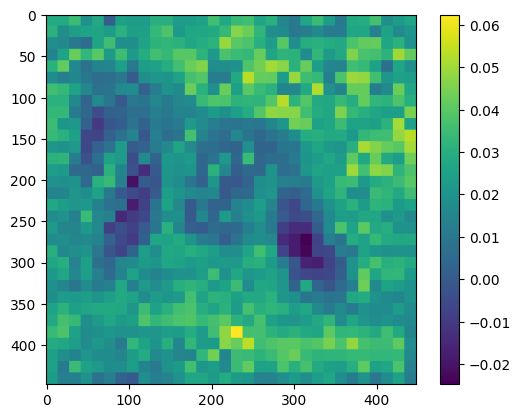

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision

threshold = 0.6
w_featmap = 448 // 14
h_featmap = 448 // 14
attentions = mean_attention_map
nh = 1
patch_size = 14

# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]
th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap, h_featmap)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu()
attentions = attentions.detach().numpy()

# show and save attentions heatmaps
#output_dir = '.'
#os.makedirs(output_dir, exist_ok=True)
#torchvision.utils.save_image(torchvision.utils.make_grid(pixel_values, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))
for j in range(nh):
    #fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
    plt.figure()
    im = plt.imshow(attentions[j])
    plt.colorbar(im)
    #plt.imsave(fname=fname, arr=attentions[j], format='png')
    #print(f"{fname} saved.")

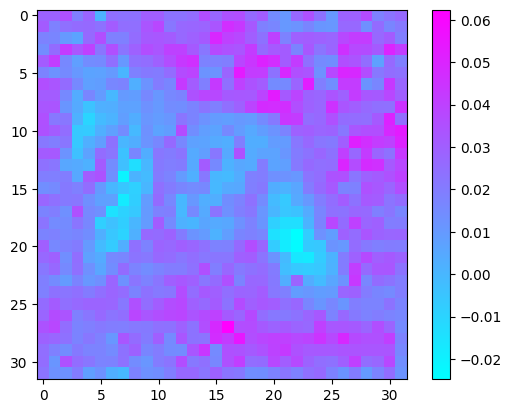

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assuming your attention map tensor is named 'attention_map' with shape [1, 1024, 36, 36]

# Compute the mean attention map across all heads
mean_attention_map = inter[-1].mean(dim=1)

# Create a heatmap by plotting the mean attention values
plt.imshow(mean_attention_map[0].cpu().detach().numpy(), cmap='cool', interpolation='nearest')

# Add colorbar for reference
plt.colorbar()

# Show the heatmap
plt.show()

In [11]:
print(inter[-1].shape)

torch.Size([1, 1024, 32, 32])


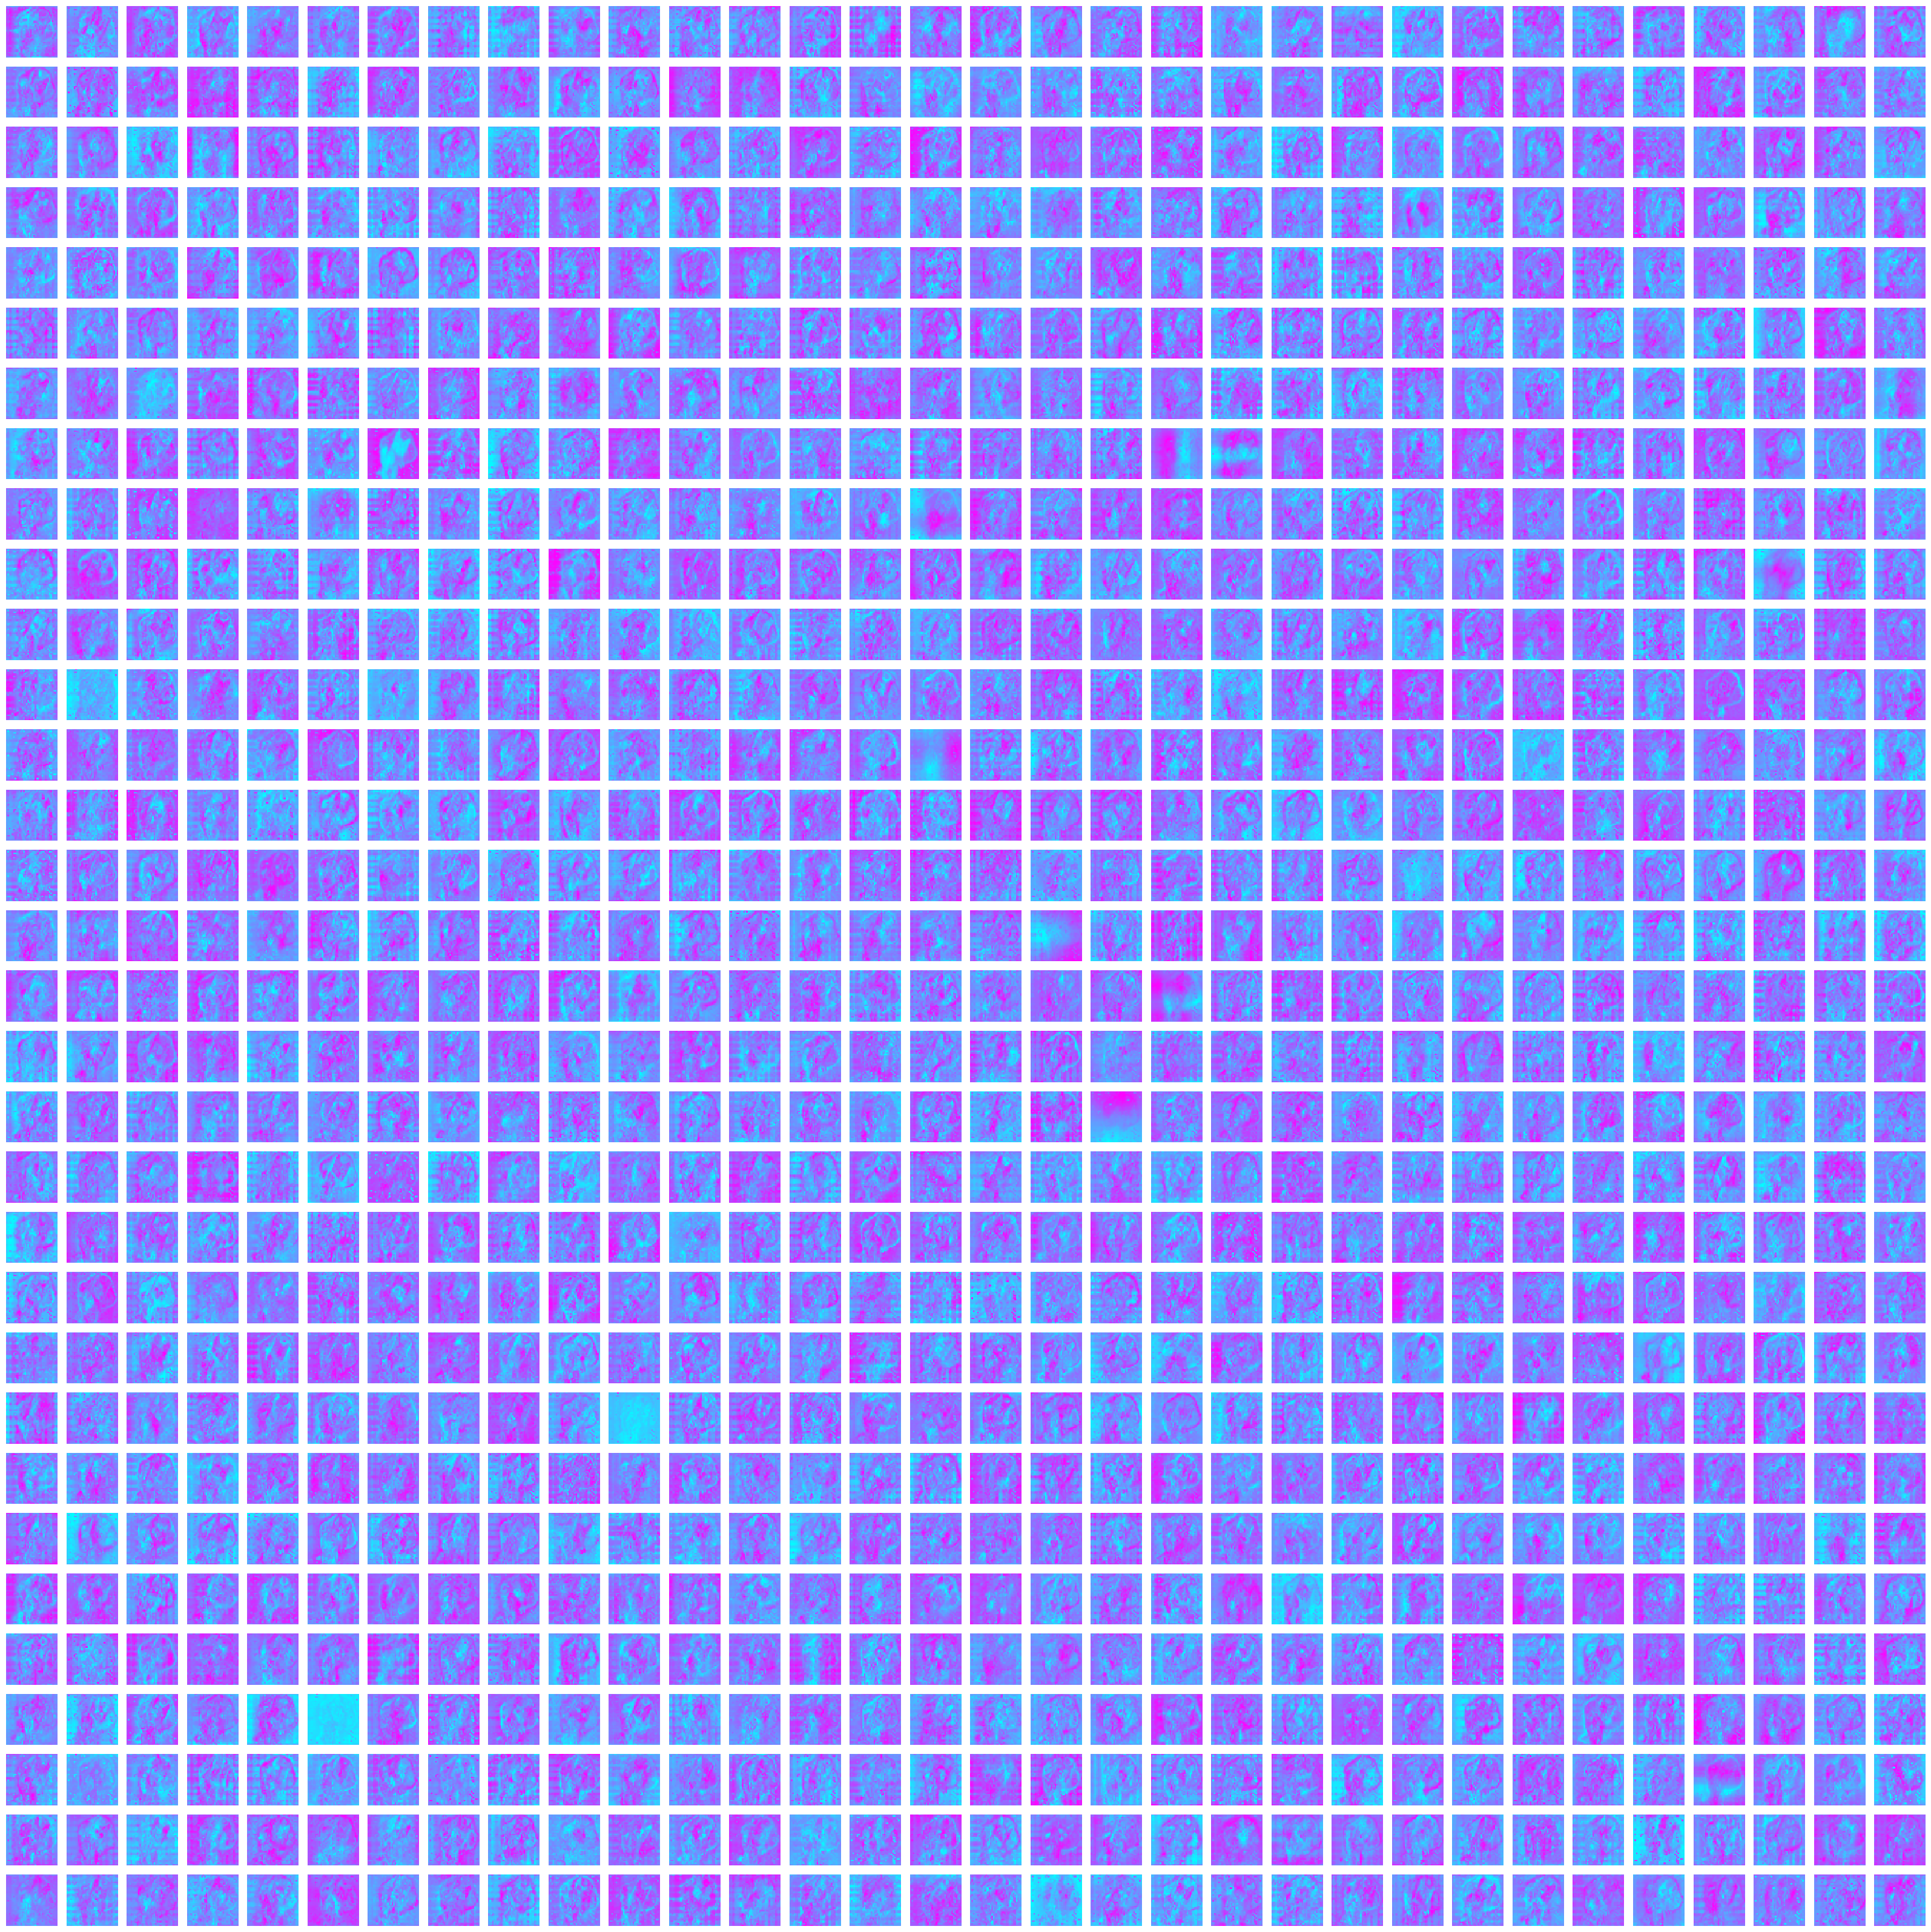

In [ ]:
attention_map = inter[0]
num_rows = 32
num_cols = 32

# Calculate the total number of attention heads
num_heads = attention_map.shape[1]

# Check that the number of heads matches the grid size (32x32)
if num_heads != num_rows * num_cols:
    raise ValueError("Number of attention heads does not match the grid size.")

# Create a figure for the grid of plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(32, 32))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate through each attention head and display it in a subplot
for head_idx in range(num_heads):
    attention_head = attention_map[0, head_idx]

    # Show the attention head in the current subplot
    axes[head_idx].imshow(attention_head.cpu().detach().numpy(), cmap='cool', interpolation='nearest')

    # Remove axis labels and ticks for cleaner visualization
    axes[head_idx].axis('off')

# Adjust layout and display the grid of attention maps
plt.tight_layout()
plt.show()

# visualization using PCA

In [10]:
print(inter[-1].shape)

torch.Size([1, 1024, 32, 32])


In [12]:
from torch.linalg import eigh
from torch.nn import functional as F

intermediate_features = inter[-1]
intermediate_features = intermediate_features.squeeze().reshape(1024, 1024)

intermediate_features = intermediate_features.T

mean = torch.mean(intermediate_features, dim=0)
std_dev = torch.std(intermediate_features, dim=0)
standardized_features = (intermediate_features - mean) / std_dev


# Calculate the covariance matrix
covariance_matrix = torch.matmul(standardized_features.T, standardized_features) / (standardized_features.size(0) - 1)

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(covariance_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = torch.argsort(eigenvalues, descending=True)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Take the top 3 eigenvectors
top_eigenvectors = eigenvectors[:, :3]

# Project the data onto the top 3 eigenvectors
reduced_features = torch.mm(standardized_features, top_eigenvectors)

In [17]:
print(reduced_features.shape)

torch.Size([1024, 3])


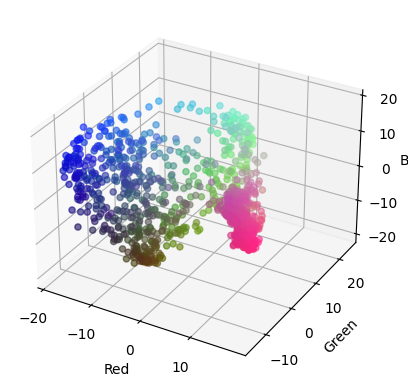

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Map each dimension to the corresponding RGB channel
red_channel = reduced_features[:, 0]
green_channel = reduced_features[:, 1]
blue_channel = reduced_features[:, 2]

# Normalize the data to the range [0, 1]
red_channel = (red_channel - red_channel.min()) / (red_channel.max() - red_channel.min())
green_channel = (green_channel - green_channel.min()) / (green_channel.max() - green_channel.min())
blue_channel = (blue_channel - blue_channel.min()) / (blue_channel.max() - blue_channel.min())

# Create an RGB color for each data point
colors = torch.stack((red_channel, green_channel, blue_channel), dim=1).detach().cpu().numpy()

# Scatter plot with RGB colors
ax.scatter(reduced_features[:, 0].detach().cpu(), reduced_features[:, 1].detach().cpu(), reduced_features[:, 2].detach().cpu(), c=colors, s=20, alpha=0.6)

# Set axis labels
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

plt.show()

In [14]:
print(reduced_features.shape)

torch.Size([1, 32, 32, 3])


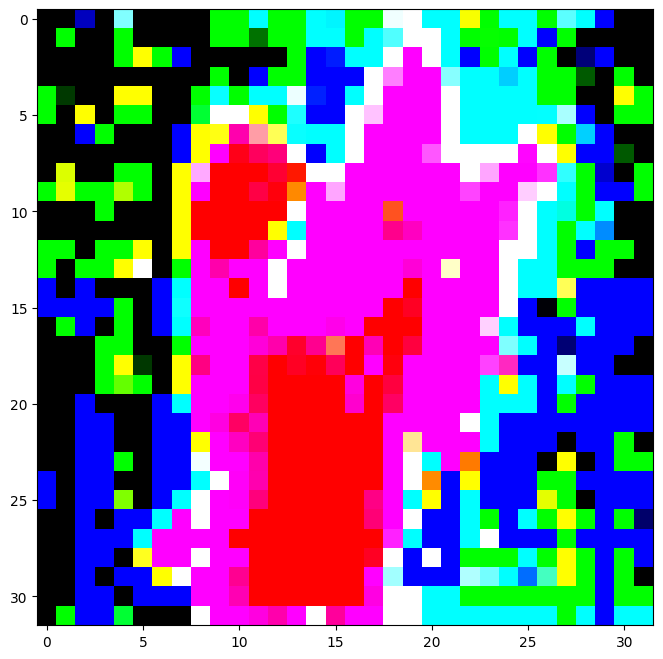

In [13]:

# Assuming 'reduced_features' is a PyTorch tensor with shape (num_samples, 3)

# Reshape the reduced features to match the 32x32 feature map
reduced_features = reduced_features.view(-1, 32, 32, 3)  # Assuming '3' for the RGB channels

# Create a figure to display the image
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# Display the image
axes.imshow(reduced_features[0].detach().cpu().numpy())  # Display the first sample's reduced feature

plt.show()

In [31]:
print(reduced_features.shape)

torch.Size([1, 32, 32, 3])


In [32]:
reduced_features = reduced_features.view(-1, 3)

# Find the minimum and maximum values for each channel
min_values = reduced_features.min(dim=0).values
max_values = reduced_features.max(dim=0).values

# Normalize the tensor between 0 and 1
normalized_features = (reduced_features - min_values) / (max_values - min_values)

# Reshape the normalized tensor back to its original shape
normalized_features = normalized_features.view(1, 32, 32, 3)

In [39]:
reduced_features_np = normalized_features.detach().cpu().numpy()

# Inspect the minimum and maximum values in the tensor
min_value = reduced_features_np.min()
max_value = reduced_features_np.max()

print(f"Min Value: {min_value}, Max Value: {max_value}")

Min Value: 0.0, Max Value: 1.0


In [40]:
import numpy as np
import cv2
import torch

# Assuming 'reduced_features' is a PyTorch tensor with shape [1, 32, 32, 3]

# Step 1: Threshold to Remove Background
# Convert the PyTorch tensor to a NumPy array
reduced_features_np = normalized_features.detach().cpu().numpy()

# Determine a threshold value (you may need to adjust this based on your data)
threshold_value = 0.6  # Adjust as needed
binary_mask = (reduced_features_np > threshold_value).astype(np.uint8)

# Step 2: Resize and Interpolate
# Resize the binary mask and the reduced features to 448x448
desired_size = (448, 448)

# Resize the binary mask using INTER_NEAREST to maintain binary nature (0 or 1)
binary_mask_resized = cv2.resize(binary_mask[0], desired_size, interpolation=cv2.INTER_NEAREST)

# Resize the reduced features using INTER_LINEAR for smoother interpolation
reduced_features_resized = cv2.resize(reduced_features_np[0], desired_size, interpolation=cv2.INTER_LINEAR)

foreground_removed = reduced_features_resized[0] * binary_mask_resized[:, :, np.newaxis]


# Convert the NumPy arrays back to PyTorch tensors if needed
binary_mask_resized_tensor = torch.tensor(binary_mask_resized)
foreground_removed_tensor = torch.tensor(foreground_removed)


# Convert the NumPy arrays back to PyTorch tensors if needed
binary_mask_resized_tensor = torch.tensor(binary_mask_resized)
reduced_features_resized_tensor = torch.tensor(reduced_features_resized)

<ipython-input-44-7a546d535b20>:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 2)


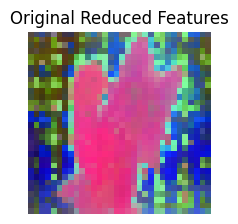

In [44]:
import matplotlib.pyplot as plt

# Plot the binary mask
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(binary_mask_resized, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

# Plot the resized and thresholded reduced features
plt.subplot(1, 2, 2)
plt.imshow(foreground_removed[0])
plt.title('Resized Reduced Features')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reduced_features_np[0])
plt.title('Original Reduced Features')
plt.axis('off')

plt.show()

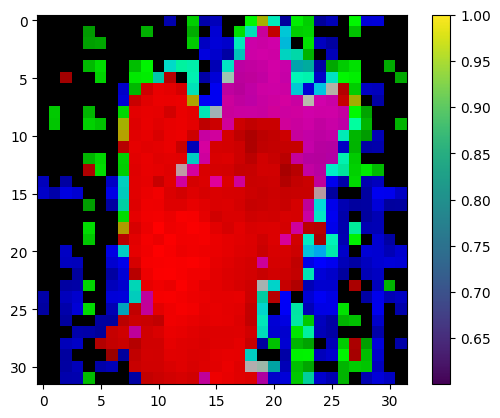

In [52]:
reduced_features_np_n = reduced_features_np.astype("float32")
thresholded_tensor_feature_map = reduced_features_np[0] > 0.6
reduced_features_np_n[0][thresholded_tensor_feature_map == 0] = np.nan
plt.imshow(reduced_features_np_n[0])
plt.colorbar()
plt.show()

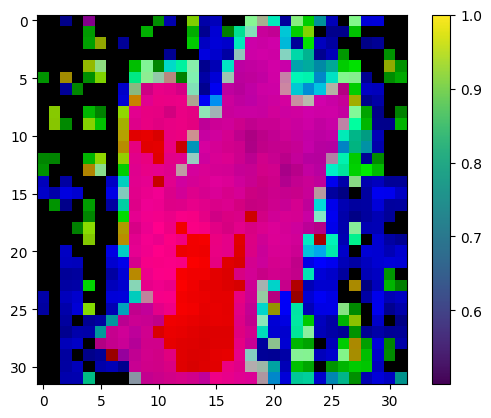

In [48]:
reduced_features_np_n = reduced_features_np.astype("float32")
thresholded_tensor_feature_map = reduced_features_np[0] > 0.5
reduced_features_np_n[0][thresholded_tensor_feature_map == 0] = np.nan
plt.imshow(reduced_features_np_n[0])
plt.colorbar()
plt.show()